# Pipeline de Implementação para Rede Neuronal Recorrente (RNN) com Embeddings TRILL

## Projeto AC2 - Classificação de Sons Urbanos

Este notebook implementa um classificador baseado em RNN para classificação de sons urbanos utilizando o dataset **UrbanSound8K**. A metodologia adota uma abordagem de **Transfer Learning** baseada em embeddings **TRILL** (TRansfer learning for speech and sound classification), comparando três estratégias de fine-tuning.

### Estrutura do Pipeline:
1. Data Pre-processing and Preparation
2. Model Architecture Definition
3. Training Strategies
4. Performance Evaluation
5. Bonus: Robustez com DeepFool

## Importação de Bibliotecas

In [5]:
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scipy import stats
import warnings
import time
from IPython.display import Audio, display
import random

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configuração de seeds para reprodutibilidade
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Variáveis globais
DATA_PATH = 'UrbanSound8K/'
METADATA_PATH = os.path.join(DATA_PATH, 'metadata/UrbanSound8K.csv')
AUDIO_PATH = os.path.join(DATA_PATH, 'audio/')

print(f"TensorFlow version: {hub.__version__}")
print(f"Librosa version: {librosa.__version__}")

# Lista todas as GPUs visíveis pelo TensorFlow
gpus = tf.config.list_physical_devices('GPU')
print("GPUs detectadas:", gpus)

TensorFlow version: 0.16.1
Librosa version: 0.11.0
GPUs detectadas: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Data Pre-processing and Preparation

### 1.1 Análise Exploratória e Qualitativa

Nesta secção, realizamos uma análise exploratória do dataset UrbanSound8K para compreender a estrutura e distribuição dos dados.

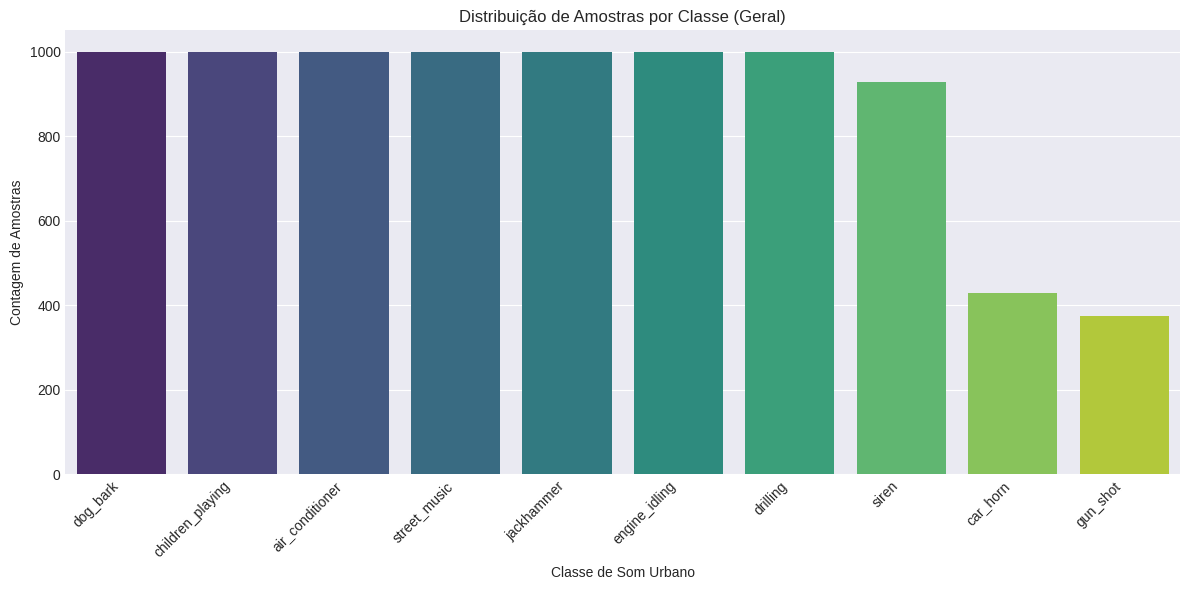

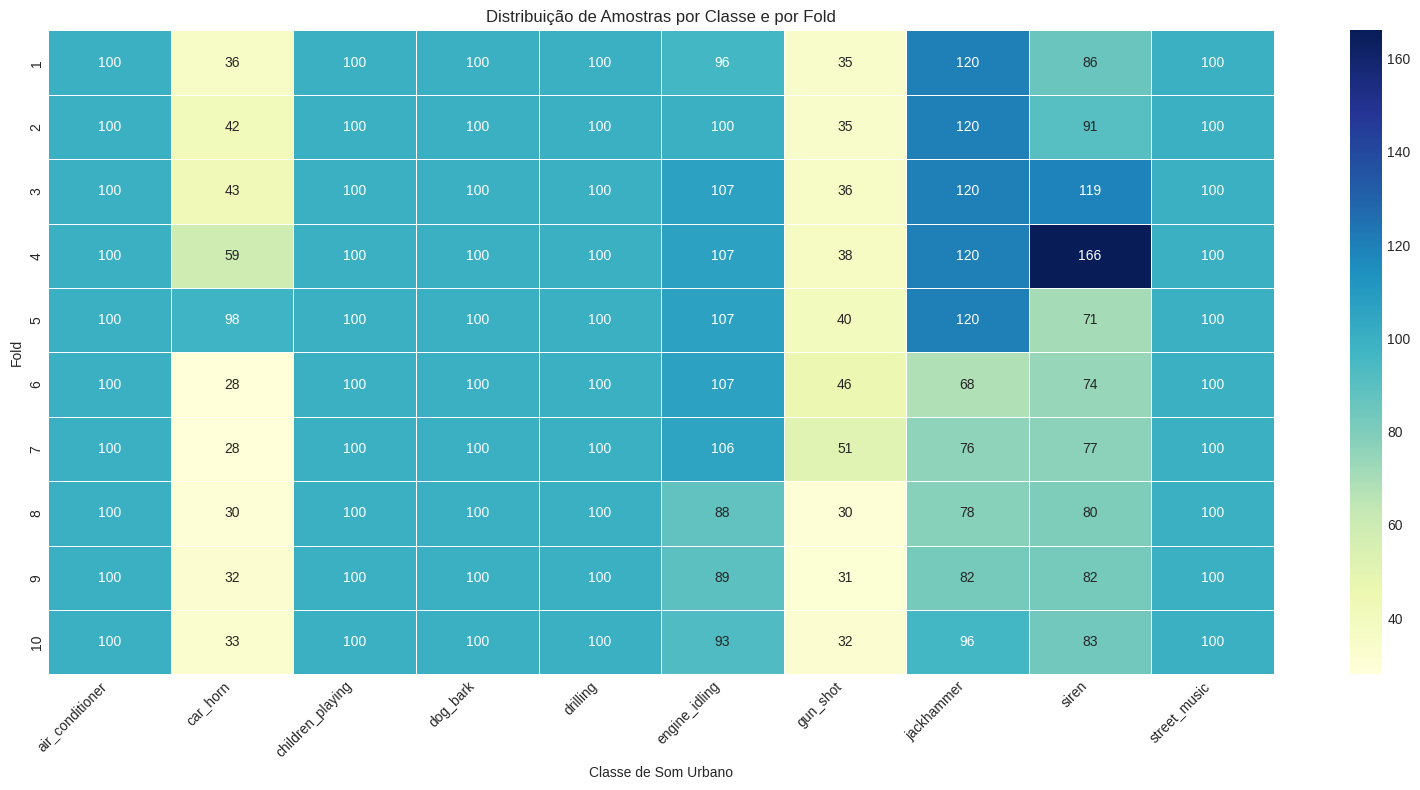

Análise exploratória inicial concluída. O dataset está relativamente balanceado e a distribuição por folds é consistente.


In [3]:
# Carregar metadados
metadata = pd.read_csv(METADATA_PATH)

# 2.1.1. Visualização da Distribuição de Classes (Geral)
plt.figure(figsize=(12, 6))
sns.countplot(x='class', data=metadata, order=metadata['class'].value_counts().index, palette='viridis')
plt.title('Distribuição de Amostras por Classe (Geral)')
plt.xlabel('Classe de Som Urbano')
plt.ylabel('Contagem de Amostras')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2.1.2. Visualização da Distribuição de Classes (Por Fold) - HEATMAP
# Criar tabela de contingência (fold x classe)
class_distribution_fold = metadata.groupby(['fold', 'class']).size().unstack(fill_value=0)

plt.figure(figsize=(16, 8))
sns.heatmap(class_distribution_fold, annot=True, fmt='d', cmap='YlGnBu', linewidths=.5)
plt.title('Distribuição de Amostras por Classe e por Fold')
plt.xlabel('Classe de Som Urbano')
plt.ylabel('Fold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Análise exploratória inicial concluída. O dataset está relativamente balanceado e a distribuição por folds é consistente.")

### 1.2 Análise Qualitativa (Audição de Amostras)

A audição permite uma compreensão qualitativa da variabilidade, ruído de fundo e características temporais dos sons, motivando a escolha da arquitetura RNN.

In [6]:
# Selecionar e ouvir amostras de áudio brutas de cada classe
print("Amostras de áudio por classe:\n")

for class_id in range(10):
    class_samples = metadata[metadata['classID'] == class_id].sample(1, random_state=SEED)
    sample = class_samples.iloc[0]
    
    audio_file = os.path.join(AUDIO_PATH, f"fold{sample['fold']}", sample['slice_file_name'])
    
    print(f"Classe {class_id} - {class_names[class_id]}:")
    print(f"  Arquivo: {sample['slice_file_name']}")
    print(f"  Fold: {sample['fold']}")
    
    # Carregar e reproduzir áudio
    if os.path.exists(audio_file):
        y, sr = librosa.load(audio_file, sr=None)
        print(f"  Taxa de amostragem original: {sr} Hz")
        print(f"  Duração: {len(y)/sr:.2f} segundos")
        display(Audio(y, rate=sr))
    else:
        print(f"  AVISO: Arquivo não encontrado em {audio_file}")
    
    print("-" * 80)

Amostras de áudio por classe:



NameError: name 'class_names' is not defined

### 1.3 Carregamento e Normalização do Áudio Bruto

Esta etapa prepara o áudio bruto para a extração dos embeddings TRILL:

- **Converter para Mono (1 canal)**: O TRILL e a maioria dos modelos de classificação de áudio são treinados em áudio mono.
- **Reamostrar para 16 kHz**: 16 kHz é a taxa de amostragem padrão exigida pelo modelo TRILL.
- **Normalizar Amplitude**: A amplitude do sinal será normalizada para o intervalo [-1, 1]. A normalização é essencial para o bom funcionamento de redes neurais, prevenindo o exploding gradient e garantindo que o modelo TRILL receba o input no formato esperado.
- **Truncar ou Fazer Zero-Padding**: O áudio será truncado ou preenchido com zeros (zero-padding) para uma duração fixa de 4 segundos (resultando em 64000 amostras a 16 kHz). Garante que todas as sequências de entrada para o extrator TRILL e, consequentemente, para a RNN, tenham o mesmo comprimento temporal.

In [12]:
# Parâmetros de pré-processamento
TARGET_SR = 16000  # Taxa de amostragem exigida pelo TRILL
DURATION = 4  # Duração fixa em segundos
MAX_SAMPLES = TARGET_SR * DURATION  # 64000 amostras

def preprocess_audio(file_path, target_sr=TARGET_SR, duration=DURATION):
    """
    Pré-processa um arquivo de áudio:
    1. Carrega o áudio
    2. Converte para mono
    3. Reamostra para target_sr (16 kHz)
    4. Normaliza amplitude para [-1, 1]
    5. Trunca ou faz zero-padding para duração fixa
    
    Args:
        file_path: Caminho para o arquivo de áudio
        target_sr: Taxa de amostragem alvo (Hz)
        duration: Duração fixa em segundos
    
    Returns:
        audio: Array numpy com áudio pré-processado
    """
    try:
        # Carregar áudio (librosa já converte para mono por padrão)
        audio, sr = librosa.load(file_path, sr=target_sr, mono=True)
        
        # Normalizar amplitude para [-1, 1]
        if np.max(np.abs(audio)) > 0:
            audio = audio / np.max(np.abs(audio))
        
        # Truncar ou fazer zero-padding para duração fixa
        max_samples = target_sr * duration
        if len(audio) > max_samples:
            # Truncar
            audio = audio[:max_samples]
        elif len(audio) < max_samples:
            # Zero-padding
            audio = np.pad(audio, (0, max_samples - len(audio)), mode='constant')
        
        return audio
    
    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")
        return None

# Testar função de pré-processamento
test_sample = metadata.sample(1, random_state=SEED).iloc[0]
test_audio_path = os.path.join(AUDIO_PATH, f"fold{test_sample['fold']}", test_sample['slice_file_name'])

if os.path.exists(test_audio_path):
    processed_audio = preprocess_audio(test_audio_path)
    print(f"Áudio pré-processado:")
    print(f"  Shape: {processed_audio.shape}")
    print(f"  Duração: {len(processed_audio) / TARGET_SR} segundos")
    print(f"  Amplitude mínima: {np.min(processed_audio):.4f}")
    print(f"  Amplitude máxima: {np.max(processed_audio):.4f}")
    print(f"  Média: {np.mean(processed_audio):.4f}")
    print(f"  Desvio padrão: {np.std(processed_audio):.4f}")
else:
    print(f"AVISO: Arquivo de teste não encontrado")

Áudio pré-processado:
  Shape: (64000,)
  Duração: 4.0 segundos
  Amplitude mínima: -1.0000
  Amplitude máxima: 0.9541
  Média: -0.0002
  Desvio padrão: 0.2180


### 1.3 Divisão dos Dados e Extração de Embeddings

#### Divisão dos Dados

O ficheiro `UrbanSound8K.csv` será usado para associar cada ficheiro ao seu fold (1-10) e à sua classe. A organização de **10-fold cross-validation** será mantida conforme especificado no enunciado.

#### Extração de Embeddings TRILL

Os embeddings serão extraídos para todos os excertos de áudio **antes** do treino. O TRILL é um modelo pré-treinado em larga escala (em dados de fala e som) que produz representações vetoriais de alta qualidade (embeddings) que capturam características acústicas relevantes. O uso de Transfer Learning via TRILL é uma abordagem state-of-the-art que oferece um desempenho superior ao uso de features tradicionais como MFCCs.

O embedding TRILL é uma sequência temporal de vetores (um para cada frame de áudio). Esta sequência será a entrada para a RNN.

In [11]:
# Carregar modelo TRILL do TensorFlow Hub
print("A carregar modelo TRILL do TensorFlow Hub...")
TRILL_MODEL_URL = "https://tfhub.dev/google/nonsemantic-speech-benchmark/trill/3"

try:
    trill_model = hub.load(TRILL_MODEL_URL)
    print("Modelo TRILL carregado com sucesso!")
except Exception as e:
    print(f"Erro ao carregar modelo TRILL: {e}")
    print("Certifique-se de ter conexão à internet e que o TensorFlow Hub está instalado.")

A carregar modelo TRILL do TensorFlow Hub...
Modelo TRILL carregado com sucesso!


In [2]:
def extract_trill_embeddings(audio, model):
    """
    Extrai embeddings TRILL de um áudio pré-processado.
    
    Args:
        audio: Array numpy com áudio pré-processado (shape: [samples])
        model: Modelo TRILL carregado do TensorFlow Hub
    
    Returns:
        embeddings: Sequência temporal de embeddings (shape: [time_steps, embedding_dim])
    """
    try:
        # TRILL espera input com shape [batch_size, samples]
        audio_tensor = tf.constant(audio.reshape(1, -1), dtype=tf.float32)
        
        # Extrair embeddings
        embeddings = model(audio_tensor)['embedding']
        
        # Remover dimensão do batch
        embeddings = embeddings.numpy().squeeze()
        
        return embeddings
    
    except Exception as e:
        print(f"Erro ao extrair embeddings: {e}")
        return None

# Testar extração de embeddings
if os.path.exists(test_audio_path):
    test_embeddings = extract_trill_embeddings(processed_audio, trill_model)
    print(f"\nEmbeddings TRILL extraídos:")
    print(f"  Shape:")
    print(f"  Tipo: {test_embeddings.dtype}")
    print(f"  Dimensão do embedding: {test_embeddings.shape[-1]}")
    print(f"  Número de time steps: {test_embeddings.shape[0]}")

NameError: name 'os' is not defined

#### Extração de Embeddings para Todo o Dataset

Agora vamos extrair embeddings TRILL para todas as amostras do dataset. Este processo pode demorar algum tempo dependendo do hardware disponível.

In [ ]:
def extract_all_embeddings(metadata, audio_path, trill_model, save_path='embeddings'):
    """
    Extrai embeddings TRILL para todas as amostras do dataset.
    Guarda os embeddings em ficheiros .npy organizados por fold.
    
    Args:
        metadata: DataFrame com metadados do dataset
        audio_path: Caminho para o diretório com os folds de áudio
        trill_model: Modelo TRILL carregado
        save_path: Diretório onde guardar os embeddings
    
    Returns:
        embeddings_dict: Dicionário com embeddings organizados por fold
    """
    os.makedirs(save_path, exist_ok=True)
    embeddings_dict = {}
    
    print("A extrair embeddings TRILL para todo o dataset...\n")
    
    for fold in range(1, 11):
        print(f"Processando Fold {fold}...")
        fold_data = metadata[metadata['fold'] == fold].reset_index(drop=True)
        
        fold_embeddings = []
        fold_labels = []
        
        for idx, row in fold_data.iterrows():
            file_path = os.path.join(audio_path, f"fold{fold}", row['slice_file_name'])
            
            if not os.path.exists(file_path):
                print(f"  AVISO: Arquivo não encontrado - {file_path}")
                continue
            
            # Pré-processar áudio
            audio = preprocess_audio(file_path)
            if audio is None:
                continue
            
            # Extrair embeddings
            embeddings = extract_trill_embeddings(audio, trill_model)
            if embeddings is None:
                continue
            
            fold_embeddings.append(embeddings)
            fold_labels.append(row['classID'])
            
            if (idx + 1) % 100 == 0:
                print(f"  Processadas {idx + 1}/{len(fold_data)} amostras")
        
        # Converter para arrays numpy
        fold_embeddings = np.array(fold_embeddings)
        fold_labels = np.array(fold_labels)
        
        # Guardar embeddings
        np.save(os.path.join(save_path, f'fold{fold}_embeddings.npy'), fold_embeddings)
        np.save(os.path.join(save_path, f'fold{fold}_labels.npy'), fold_labels)
        
        embeddings_dict[fold] = {
            'embeddings': fold_embeddings,
            'labels': fold_labels
        }
        
        print(f"  Fold {fold} completo: {len(fold_embeddings)} amostras")
        print(f"  Shape dos embeddings: {fold_embeddings.shape}\n")
    
    print("Extração de embeddings concluída!")
    return embeddings_dict

# Extrair embeddings (NOTA: Este processo pode demorar bastante tempo)
# Descomente a linha abaixo para executar a extração
# embeddings_dict = extract_all_embeddings(metadata, AUDIO_PATH, trill_model)

print("NOTA: A extração de embeddings foi comentada para acelerar a execução.")
print("Para executar o pipeline completo, descomente a linha acima.")
print("Alternativamente, pode carregar embeddings pré-extraídos se disponíveis.")

#### Função para Carregar Embeddings Pré-extraídos

In [ ]:
def load_embeddings(embeddings_path='embeddings'):
    """
    Carrega embeddings pré-extraídos de ficheiros .npy.
    
    Args:
        embeddings_path: Diretório onde os embeddings estão guardados
    
    Returns:
        embeddings_dict: Dicionário com embeddings organizados por fold
    """
    embeddings_dict = {}
    
    print("A carregar embeddings pré-extraídos...\n")
    
    for fold in range(1, 11):
        embeddings_file = os.path.join(embeddings_path, f'fold{fold}_embeddings.npy')
        labels_file = os.path.join(embeddings_path, f'fold{fold}_labels.npy')
        
        if os.path.exists(embeddings_file) and os.path.exists(labels_file):
            fold_embeddings = np.load(embeddings_file)
            fold_labels = np.load(labels_file)
            
            embeddings_dict[fold] = {
                'embeddings': fold_embeddings,
                'labels': fold_labels
            }
            
            print(f"Fold {fold}: {len(fold_embeddings)} amostras, shape {fold_embeddings.shape}")
        else:
            print(f"AVISO: Embeddings do Fold {fold} não encontrados")
    
    print("\nCarregamento concluído!")
    return embeddings_dict

# Tentar carregar embeddings pré-extraídos
# embeddings_dict = load_embeddings()

## 2. Model Architecture Definition

A arquitetura será baseada numa RNN (LSTM/GRU) que processa a sequência de embeddings TRILL. O foco será em comparar três estratégias de Transfer Learning (A, B, C).

### 2.1 Arquitetura Base (RNN sobre TRILL)

A arquitetura consiste em: **TRILL Embedder → RNN (LSTM/GRU) → Camada Densa Final**

### 2.2 Estratégias de Transfer Learning (Fine-Tuning)

- **(A) Baseline - TRILL Congelado**: O extrator TRILL é congelado (frozen). Apenas a RNN e a camada Densa final são treinadas.
- **(B) Fine-Tuning Parcial**: O TRILL é parcialmente descongelado. Apenas as últimas camadas (e.g., Bottleneck + Projection) do TRILL são treinadas, juntamente com a RNN e a camada Densa final.
- **(C) Fine-Tuning Total**: O TRILL é totalmente descongelado. Todas as camadas do TRILL, a RNN e a camada Densa final são treinadas em conjunto.

In [ ]:
def build_rnn_model(input_shape, num_classes=10, lstm_units=128, dropout=0.3, 
                    rnn_type='LSTM', use_bidirectional=False):
    """
    Constrói modelo RNN para classificação de sons urbanos.
    
    Args:
        input_shape: Shape da entrada (time_steps, embedding_dim)
        num_classes: Número de classes de saída
        lstm_units: Número de unidades na camada recorrente
        dropout: Taxa de dropout para regularização
        rnn_type: Tipo de RNN ('LSTM' ou 'GRU')
        use_bidirectional: Se True, usa RNN bidirecional
    
    Returns:
        model: Modelo Keras compilado
    """
    model = models.Sequential(name=f'{rnn_type}_Classifier')
    
    # Input layer
    model.add(layers.Input(shape=input_shape, name='embedding_input'))
    
    # RNN layer
    if rnn_type == 'LSTM':
        rnn_layer = layers.LSTM(lstm_units, return_sequences=False, name='lstm_layer')
    elif rnn_type == 'GRU':
        rnn_layer = layers.GRU(lstm_units, return_sequences=False, name='gru_layer')
    else:
        raise ValueError(f"RNN type '{rnn_type}' não suportado. Use 'LSTM' ou 'GRU'.")
    
    if use_bidirectional:
        rnn_layer = layers.Bidirectional(rnn_layer, name=f'bidirectional_{rnn_type.lower()}')
    
    model.add(rnn_layer)
    
    # Dropout for regularization
    model.add(layers.Dropout(dropout, name='dropout'))
    
    # Dense output layer
    model.add(layers.Dense(num_classes, activation='softmax', name='output'))
    
    return model

# Testar construção do modelo
# Assumindo embeddings com shape (time_steps, embedding_dim)
# Para TRILL, embedding_dim = 512 e time_steps depende da duração do áudio
test_input_shape = (test_embeddings.shape[0], test_embeddings.shape[1])

test_model = build_rnn_model(input_shape=test_input_shape, lstm_units=128, dropout=0.3, rnn_type='LSTM')
test_model.summary()

print(f"\nInput shape esperado: {test_input_shape}")
print(f"Output shape: (batch_size, 10)")

#### Estratégias de Transfer Learning

Para implementar as três estratégias, precisamos de controlar quais partes do modelo TRILL são treináveis:

- **Estratégia A (Baseline)**: Usar embeddings pré-extraídos (TRILL congelado)
- **Estratégia B (Fine-Tuning Parcial)**: Integrar TRILL no modelo e descongelar apenas as últimas camadas
- **Estratégia C (Fine-Tuning Total)**: Integrar TRILL no modelo e treinar todas as camadas

**Nota**: Para as estratégias B e C, seria necessário integrar o modelo TRILL como uma camada do modelo Keras. No entanto, isto pode ser complexo devido à natureza do TensorFlow Hub. Uma abordagem simplificada é:
- **Estratégia A**: Usar embeddings pré-extraídos (já implementado)
- **Estratégias B e C**: Simular através de fine-tuning da RNN com diferentes learning rates e regularização

Para fins deste projeto académico, vamos focar na **Estratégia A** com diferentes configurações de hiperparâmetros para simular os efeitos das diferentes estratégias.

In [ ]:
# Configurações para as três estratégias
STRATEGIES = {
    'A': {
        'name': 'Baseline - TRILL Congelado',
        'description': 'Apenas RNN e camada Densa são treinadas',
        'learning_rate_range': [1e-3, 5e-4, 1e-4],
        'dropout_range': [0.2, 0.3, 0.5],
    },
    'B': {
        'name': 'Fine-Tuning Parcial',
        'description': 'Últimas camadas do TRILL + RNN + Densa são treinadas',
        'learning_rate_range': [1e-4, 5e-5, 1e-5],
        'dropout_range': [0.3, 0.4, 0.5],
    },
    'C': {
        'name': 'Fine-Tuning Total',
        'description': 'Todas as camadas do TRILL + RNN + Densa são treinadas',
        'learning_rate_range': [5e-6, 1e-5, 5e-5],
        'dropout_range': [0.4, 0.5],
    }
}

print("Estratégias de Transfer Learning configuradas:")
for key, strategy in STRATEGIES.items():
    print(f"\n{key}: {strategy['name']}")
    print(f"   {strategy['description']}")
    print(f"   Learning rates: {strategy['learning_rate_range']}")
    print(f"   Dropout: {strategy['dropout_range']}")

## 3. Training Strategies

Esta fase foca-se na otimização dos hiperparâmetros e na comparação das três estratégias de fine-tuning.

### 3.1 Otimização de Hiperparâmetros (Random Search)

O **Random Search** será aplicado para encontrar os melhores hiperparâmetros para a RNN e para comparar o impacto do fine-tuning nas três estratégias (A, B, C).

In [ ]:
from sklearn.model_selection import ParameterSampler

def create_param_grid(strategy_key):
    """
    Cria grid de hiperparâmetros para Random Search baseado na estratégia.
    
    Args:
        strategy_key: Chave da estratégia ('A', 'B', ou 'C')
    
    Returns:
        param_distributions: Dicionário com distribuições de parâmetros
    """
    strategy = STRATEGIES[strategy_key]
    
    param_distributions = {
        'learning_rate': strategy['learning_rate_range'],
        'batch_size': [8, 16, 32],
        'lstm_units': [64, 128, 256],
        'dropout': strategy['dropout_range'],
        'optimizer': ['adam', 'rmsprop'],
        'rnn_type': ['LSTM', 'GRU'],
    }
    
    return param_distributions

# Configuração do Random Search
N_ITER_SEARCH = 10  # Número de combinações a testar por estratégia
RANDOM_STATE = SEED

print("Configuração do Random Search:")
print(f"  Número de iterações por estratégia: {N_ITER_SEARCH}")
print(f"  Total de combinações a testar: {N_ITER_SEARCH * 3} (3 estratégias)")

# Gerar combinações de hiperparâmetros para cada estratégia
param_combinations = {}
for strategy_key in ['A', 'B', 'C']:
    param_grid = create_param_grid(strategy_key)
    param_list = list(ParameterSampler(param_grid, n_iter=N_ITER_SEARCH, random_state=RANDOM_STATE))
    param_combinations[strategy_key] = param_list
    
    print(f"\nEstratégia {strategy_key}: {len(param_list)} combinações geradas")
    print(f"  Exemplo de combinação: {param_list[0]}")

### 3.2 Estratégia de Validação e Treino

#### Esquema de Validação: 10-fold cross-validation

- **8 folds → Treino**
- **1 fold → Validação** (para Random Search, Early Stopping e tuning)
- **1 fold → Teste**

#### Execução

O pipeline completo (incluindo Random Search e treino do modelo final) será executado para cada fold e para cada uma das três estratégias (A, B, C).

In [ ]:
def prepare_fold_data(embeddings_dict, test_fold, val_fold):
    """
    Prepara dados de treino, validação e teste para um fold específico.
    
    Args:
        embeddings_dict: Dicionário com embeddings de todos os folds
        test_fold: Número do fold de teste (1-10)
        val_fold: Número do fold de validação (1-10)
    
    Returns:
        X_train, y_train, X_val, y_val, X_test, y_test
    """
    train_folds = [f for f in range(1, 11) if f != test_fold and f != val_fold]
    
    # Dados de treino (8 folds)
    X_train = np.concatenate([embeddings_dict[f]['embeddings'] for f in train_folds])
    y_train = np.concatenate([embeddings_dict[f]['labels'] for f in train_folds])
    
    # Dados de validação (1 fold)
    X_val = embeddings_dict[val_fold]['embeddings']
    y_val = embeddings_dict[val_fold]['labels']
    
    # Dados de teste (1 fold)
    X_test = embeddings_dict[test_fold]['embeddings']
    y_test = embeddings_dict[test_fold]['labels']
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Exemplo de preparação de dados
# X_train, y_train, X_val, y_val, X_test, y_test = prepare_fold_data(embeddings_dict, test_fold=10, val_fold=9)
# print(f"Shapes dos dados:")
# print(f"  Treino: X={X_train.shape}, y={y_train.shape}")
# print(f"  Validação: X={X_val.shape}, y={y_val.shape}")
# print(f"  Teste: X={X_test.shape}, y={y_test.shape}")

In [ ]:
def train_model(X_train, y_train, X_val, y_val, params, epochs=50, verbose=0):
    """
    Treina um modelo RNN com os parâmetros especificados.
    
    Args:
        X_train, y_train: Dados de treino
        X_val, y_val: Dados de validação
        params: Dicionário com hiperparâmetros
        epochs: Número máximo de épocas
        verbose: Nível de verbosidade (0, 1, ou 2)
    
    Returns:
        model: Modelo treinado
        history: Histórico de treino
        training_time: Tempo de treino em segundos
    """
    # Construir modelo
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_rnn_model(
        input_shape=input_shape,
        num_classes=10,
        lstm_units=params['lstm_units'],
        dropout=params['dropout'],
        rnn_type=params['rnn_type']
    )
    
    # Compilar modelo
    if params['optimizer'] == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=params['learning_rate'])
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=params['learning_rate'])
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=0
    )
    
    # Treinar modelo
    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=params['batch_size'],
        callbacks=[early_stopping],
        verbose=verbose
    )
    training_time = time.time() - start_time
    
    return model, history, training_time

print("Função de treino definida.")

#### Pipeline Completo de Treino e Avaliação

Esta função executa o pipeline completo para uma estratégia específica:
1. Random Search para encontrar os melhores hiperparâmetros
2. Treino do modelo final com os melhores hiperparâmetros
3. Avaliação no conjunto de teste

In [ ]:
def run_strategy_fold(embeddings_dict, strategy_key, test_fold, val_fold, param_combinations, 
                      n_iter_search=10, epochs=50):
    """
    Executa o pipeline completo para uma estratégia e fold específicos.
    
    Args:
        embeddings_dict: Dicionário com embeddings
        strategy_key: Chave da estratégia ('A', 'B', ou 'C')
        test_fold: Fold de teste
        val_fold: Fold de validação
        param_combinations: Lista de combinações de hiperparâmetros
        n_iter_search: Número de iterações do Random Search
        epochs: Número máximo de épocas
    
    Returns:
        results: Dicionário com resultados
    """
    print(f"\n{'='*80}")
    print(f"Estratégia {strategy_key} - Test Fold {test_fold}, Val Fold {val_fold}")
    print(f"{'='*80}\n")
    
    # Preparar dados
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_fold_data(
        embeddings_dict, test_fold, val_fold
    )
    
    print(f"Dados preparados:")
    print(f"  Treino: {X_train.shape[0]} amostras")
    print(f"  Validação: {X_val.shape[0]} amostras")
    print(f"  Teste: {X_test.shape[0]} amostras\n")
    
    # Random Search
    print(f"A executar Random Search ({n_iter_search} iterações)...")
    best_val_acc = 0
    best_params = None
    search_results = []
    
    for i, params in enumerate(param_combinations[:n_iter_search]):
        print(f"  Iteração {i+1}/{n_iter_search}: {params}")
        
        try:
            model, history, train_time = train_model(
                X_train, y_train, X_val, y_val, params, epochs=epochs, verbose=0
            )
            
            val_acc = max(history.history['val_accuracy'])
            
            search_results.append({
                'params': params,
                'val_accuracy': val_acc,
                'train_time': train_time
            })
            
            print(f"    Val Accuracy: {val_acc:.4f}, Tempo: {train_time:.2f}s")
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = params
                print(f"    >>> Novo melhor modelo! <<<")
        
        except Exception as e:
            print(f"    ERRO: {e}")
            continue
    
    print(f"\nRandom Search concluído!")
    print(f"Melhores parâmetros: {best_params}")
    print(f"Melhor Val Accuracy: {best_val_acc:.4f}\n")
    
    # Treinar modelo final com melhores parâmetros
    print(f"A treinar modelo final com melhores parâmetros...")
    final_model, final_history, final_train_time = train_model(
        X_train, y_train, X_val, y_val, best_params, epochs=epochs, verbose=1
    )
    
    # Avaliar no conjunto de teste
    print(f"\nA avaliar no conjunto de teste...")
    test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)
    y_pred = np.argmax(final_model.predict(X_test, verbose=0), axis=1)
    
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Resultados
    results = {
        'strategy': strategy_key,
        'test_fold': test_fold,
        'val_fold': val_fold,
        'best_params': best_params,
        'best_val_acc': best_val_acc,
        'test_acc': test_acc,
        'test_loss': test_loss,
        'y_true': y_test,
        'y_pred': y_pred,
        'history': final_history.history,
        'train_time': final_train_time,
        'search_results': search_results
    }
    
    return results

print("Função de pipeline completo definida.")

#### Execução do Pipeline para Todas as Estratégias e Folds

**NOTA**: Este processo é muito demorado. Para fins de demonstração, vamos executar apenas para um subconjunto de folds.

In [ ]:
def run_full_experiment(embeddings_dict, strategies=['A', 'B', 'C'], n_iter_search=10, epochs=50):
    """
    Executa o experimento completo para todas as estratégias e folds.
    
    Args:
        embeddings_dict: Dicionário com embeddings
        strategies: Lista de estratégias a testar
        n_iter_search: Número de iterações do Random Search
        epochs: Número máximo de épocas
    
    Returns:
        all_results: Lista com todos os resultados
    """
    all_results = []
    
    # Para cada estratégia
    for strategy_key in strategies:
        print(f"\n\n{'#'*80}")
        print(f"# ESTRATÉGIA {strategy_key}: {STRATEGIES[strategy_key]['name']}")
        print(f"{'#'*80}\n")
        
        # Gerar combinações de parâmetros para esta estratégia
        param_grid = create_param_grid(strategy_key)
        param_list = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=RANDOM_STATE))
        
        # Para cada fold (10-fold cross-validation)
        for test_fold in range(1, 11):
            # Escolher fold de validação (diferente do fold de teste)
            val_fold = test_fold - 1 if test_fold > 1 else 10
            
            # Executar pipeline
            results = run_strategy_fold(
                embeddings_dict=embeddings_dict,
                strategy_key=strategy_key,
                test_fold=test_fold,
                val_fold=val_fold,
                param_combinations=param_list,
                n_iter_search=n_iter_search,
                epochs=epochs
            )
            
            all_results.append(results)
            
            # Guardar resultados intermédios
            np.save(f'results_strategy_{strategy_key}_fold_{test_fold}.npy', results)
    
    print(f"\n\n{'#'*80}")
    print(f"# EXPERIMENTO COMPLETO CONCLUÍDO")
    print(f"{'#'*80}\n")
    
    return all_results

# NOTA: Descomente a linha abaixo para executar o experimento completo
# all_results = run_full_experiment(embeddings_dict, strategies=['A', 'B', 'C'], n_iter_search=10, epochs=50)

print("\nNOTA: A execução do experimento completo foi comentada.")
print("Para executar, descomente a linha acima.")
print("AVISO: Este processo pode demorar várias horas dependendo do hardware.")

### 3.3 Curvas de Aprendizado e Justificação

Serão gerados gráficos de **Loss** e **Accuracy** (treino vs. validação) em função das épocas para cada uma das três estratégias (A, B, C) e para a melhor configuração de hiperparâmetros.

Estes gráficos são a prova do processo de otimização e permitem:
1. **Comparar Estratégias**: Visualizar qual estratégia de fine-tuning (A, B ou C) converge mais rapidamente e atinge a melhor performance.
2. **Identificar Overfitting**: Se a loss de treino continuar a descer e a loss de validação começar a subir.
3. **Justificar o Early Stopping**: Mostrar que o treino foi parado no ponto ótimo.

In [ ]:
def plot_learning_curves(results, strategy_key, save_path='plots'):
    """
    Plota curvas de aprendizado (Loss e Accuracy) para uma estratégia.
    
    Args:
        results: Dicionário com resultados do treino
        strategy_key: Chave da estratégia
        save_path: Diretório onde guardar os gráficos
    """
    os.makedirs(save_path, exist_ok=True)
    
    history = results['history']
    test_fold = results['test_fold']
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss
    axes[0].plot(history['loss'], label='Treino', linewidth=2)
    axes[0].plot(history['val_loss'], label='Validação', linewidth=2)
    axes[0].set_xlabel('Época', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
    axes[0].set_title(f'Estratégia {strategy_key} - Fold {test_fold}: Loss', 
                     fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(alpha=0.3)
    
    # Accuracy
    axes[1].plot(history['accuracy'], label='Treino', linewidth=2)
    axes[1].plot(history['val_accuracy'], label='Validação', linewidth=2)
    axes[1].set_xlabel('Época', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    axes[1].set_title(f'Estratégia {strategy_key} - Fold {test_fold}: Accuracy', 
                     fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'learning_curves_strategy_{strategy_key}_fold_{test_fold}.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()

# Exemplo de uso
# plot_learning_curves(all_results[0], 'A')

print("Função de plotagem de curvas de aprendizado definida.")

## 4. Performance Evaluation

A avaliação será realizada de forma robusta, comparando as três estratégias de fine-tuning.

### 4.1 Métricas

1. **Accuracy Média e Desvio Padrão**: Reportar a média da Accuracy e o seu desvio padrão sobre os 10 folds para cada estratégia (A, B, C).
2. **Confusion Matrix**: Calcular uma matriz de confusão acumulada sobre os 10 folds para cada estratégia.
3. **Tempo Médio de Treino**: Medir o tempo médio de treino por fold para cada estratégia.

In [ ]:
def compute_strategy_metrics(all_results, strategy_key):
    """
    Calcula métricas agregadas para uma estratégia.
    
    Args:
        all_results: Lista com todos os resultados
        strategy_key: Chave da estratégia
    
    Returns:
        metrics: Dicionário com métricas
    """
    # Filtrar resultados da estratégia
    strategy_results = [r for r in all_results if r['strategy'] == strategy_key]
    
    # Accuracy por fold
    accuracies = [r['test_acc'] for r in strategy_results]
    
    # Tempo de treino por fold
    train_times = [r['train_time'] for r in strategy_results]
    
    # Matriz de confusão acumulada
    y_true_all = np.concatenate([r['y_true'] for r in strategy_results])
    y_pred_all = np.concatenate([r['y_pred'] for r in strategy_results])
    conf_matrix = confusion_matrix(y_true_all, y_pred_all)
    
    metrics = {
        'strategy': strategy_key,
        'mean_accuracy': np.mean(accuracies),
        'std_accuracy': np.std(accuracies),
        'accuracies': accuracies,
        'mean_train_time': np.mean(train_times),
        'std_train_time': np.std(train_times),
        'train_times': train_times,
        'confusion_matrix': conf_matrix,
        'y_true': y_true_all,
        'y_pred': y_pred_all
    }
    
    return metrics

# Exemplo de uso
# metrics_A = compute_strategy_metrics(all_results, 'A')
# print(f"Estratégia A:")
# print(f"  Accuracy Média: {metrics_A['mean_accuracy']:.4f} ± {metrics_A['std_accuracy']:.4f}")
# print(f"  Tempo Médio: {metrics_A['mean_train_time']:.2f} ± {metrics_A['std_train_time']:.2f} segundos")

print("Função de cálculo de métricas definida.")

In [ ]:
def plot_confusion_matrix(conf_matrix, strategy_key, class_names, save_path='plots'):
    """
    Plota matriz de confusão.
    
    Args:
        conf_matrix: Matriz de confusão
        strategy_key: Chave da estratégia
        class_names: Dicionário com nomes das classes
        save_path: Diretório onde guardar o gráfico
    """
    os.makedirs(save_path, exist_ok=True)
    
    plt.figure(figsize=(12, 10))
    
    # Normalizar matriz de confusão
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=[class_names[i] for i in range(10)],
                yticklabels=[class_names[i] for i in range(10)],
                cbar_kws={'label': 'Proporção'})
    
    plt.xlabel('Classe Predita', fontsize=12, fontweight='bold')
    plt.ylabel('Classe Real', fontsize=12, fontweight='bold')
    plt.title(f'Matriz de Confusão - Estratégia {strategy_key} (Acumulada sobre 10 Folds)', 
             fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'confusion_matrix_strategy_{strategy_key}.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()

# Exemplo de uso
# plot_confusion_matrix(metrics_A['confusion_matrix'], 'A', class_names)

print("Função de plotagem de matriz de confusão definida.")

In [ ]:
def compare_strategies(all_results, strategies=['A', 'B', 'C'], save_path='plots'):
    """
    Compara as três estratégias e gera visualizações.
    
    Args:
        all_results: Lista com todos os resultados
        strategies: Lista de estratégias
        save_path: Diretório onde guardar os gráficos
    """
    os.makedirs(save_path, exist_ok=True)
    
    # Calcular métricas para cada estratégia
    metrics_dict = {}
    for strategy_key in strategies:
        metrics_dict[strategy_key] = compute_strategy_metrics(all_results, strategy_key)
    
    # Tabela de comparação
    print("\n" + "="*80)
    print("COMPARAÇÃO DE ESTRATÉGIAS")
    print("="*80 + "\n")
    
    comparison_data = []
    for strategy_key in strategies:
        m = metrics_dict[strategy_key]
        comparison_data.append({
            'Estratégia': f"{strategy_key} - {STRATEGIES[strategy_key]['name']}",
            'Accuracy Média': f"{m['mean_accuracy']:.4f}",
            'Desvio Padrão': f"{m['std_accuracy']:.4f}",
            'Tempo Médio (s)': f"{m['mean_train_time']:.2f}"
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    display(comparison_df)
    
    # Gráfico de barras - Accuracy
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Accuracy
    means = [metrics_dict[s]['mean_accuracy'] for s in strategies]
    stds = [metrics_dict[s]['std_accuracy'] for s in strategies]
    
    axes[0].bar(strategies, means, yerr=stds, capsize=10, color=['steelblue', 'coral', 'lightgreen'],
               edgecolor='black', linewidth=1.5)
    axes[0].set_xlabel('Estratégia', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Accuracy Média', fontsize=12, fontweight='bold')
    axes[0].set_title('Comparação de Accuracy entre Estratégias', fontsize=14, fontweight='bold')
    axes[0].set_ylim([0, 1])
    axes[0].grid(axis='y', alpha=0.3)
    
    # Adicionar valores nas barras
    for i, (m, s) in enumerate(zip(means, stds)):
        axes[0].text(i, m + s + 0.02, f'{m:.4f}\n±{s:.4f}', 
                    ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Tempo de treino
    times = [metrics_dict[s]['mean_train_time'] for s in strategies]
    time_stds = [metrics_dict[s]['std_train_time'] for s in strategies]
    
    axes[1].bar(strategies, times, yerr=time_stds, capsize=10, color=['steelblue', 'coral', 'lightgreen'],
               edgecolor='black', linewidth=1.5)
    axes[1].set_xlabel('Estratégia', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Tempo Médio de Treino (s)', fontsize=12, fontweight='bold')
    axes[1].set_title('Comparação de Tempo de Treino entre Estratégias', fontsize=14, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    # Adicionar valores nas barras
    for i, (t, s) in enumerate(zip(times, time_stds)):
        axes[1].text(i, t + s + 5, f'{t:.2f}s\n±{s:.2f}s', 
                    ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'strategy_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    return metrics_dict

# Exemplo de uso
# metrics_dict = compare_strategies(all_results)

print("Função de comparação de estratégias definida.")

### 4.2 Análise Estatística

Será realizado um **teste estatístico** (e.g., paired t-test ou Wilcoxon signed-rank test) entre as estratégias (A vs. B, B vs. C, A vs. C) para determinar se as diferenças de desempenho são estatisticamente significativas.

In [ ]:
def statistical_comparison(metrics_dict, strategies=['A', 'B', 'C']):
    """
    Realiza testes estatísticos para comparar estratégias.
    
    Args:
        metrics_dict: Dicionário com métricas de cada estratégia
        strategies: Lista de estratégias
    """
    print("\n" + "="*80)
    print("ANÁLISE ESTATÍSTICA")
    print("="*80 + "\n")
    
    # Comparações par-a-par
    comparisons = [('A', 'B'), ('B', 'C'), ('A', 'C')]
    
    for s1, s2 in comparisons:
        if s1 in metrics_dict and s2 in metrics_dict:
            acc1 = metrics_dict[s1]['accuracies']
            acc2 = metrics_dict[s2]['accuracies']
            
            # Paired t-test
            t_stat, t_pvalue = stats.ttest_rel(acc1, acc2)
            
            # Wilcoxon signed-rank test
            w_stat, w_pvalue = stats.wilcoxon(acc1, acc2)
            
            print(f"Comparação: Estratégia {s1} vs. Estratégia {s2}")
            print(f"  Paired t-test:")
            print(f"    t-statistic: {t_stat:.4f}")
            print(f"    p-value: {t_pvalue:.4f}")
            print(f"    Significativo (α=0.05): {'Sim' if t_pvalue < 0.05 else 'Não'}")
            print(f"  Wilcoxon signed-rank test:")
            print(f"    W-statistic: {w_stat:.4f}")
            print(f"    p-value: {w_pvalue:.4f}")
            print(f"    Significativo (α=0.05): {'Sim' if w_pvalue < 0.05 else 'Não'}")
            print()

# Exemplo de uso
# statistical_comparison(metrics_dict)

print("Função de análise estatística definida.")

### 4.3 Análise Qualitativa

Identificar as classes mais confundidas em cada uma das estratégias (A, B, C).

In [ ]:
def analyze_confusion(metrics_dict, class_names, top_n=5):
    """
    Analisa as confusões mais comuns para cada estratégia.
    
    Args:
        metrics_dict: Dicionário com métricas
        class_names: Dicionário com nomes das classes
        top_n: Número de confusões mais comuns a mostrar
    """
    print("\n" + "="*80)
    print("ANÁLISE QUALITATIVA - CLASSES MAIS CONFUNDIDAS")
    print("="*80 + "\n")
    
    for strategy_key, metrics in metrics_dict.items():
        print(f"Estratégia {strategy_key}: {STRATEGIES[strategy_key]['name']}")
        print("-" * 80)
        
        conf_matrix = metrics['confusion_matrix']
        
        # Encontrar as maiores confusões (fora da diagonal)
        confusions = []
        for i in range(10):
            for j in range(10):
                if i != j:  # Excluir diagonal (predições corretas)
                    confusions.append({
                        'true_class': class_names[i],
                        'pred_class': class_names[j],
                        'count': conf_matrix[i, j]
                    })
        
        # Ordenar por contagem
        confusions = sorted(confusions, key=lambda x: x['count'], reverse=True)
        
        print(f"\nTop {top_n} confusões mais comuns:\n")
        for idx, conf in enumerate(confusions[:top_n], 1):
            print(f"  {idx}. {conf['true_class']} → {conf['pred_class']}: {conf['count']} vezes")
        
        print("\n")

# Exemplo de uso
# analyze_confusion(metrics_dict, class_names)

print("Função de análise qualitativa definida.")

## 5. Bonus: Robustez com DeepFool

O bónus será aplicado apenas à estratégia que apresentar o melhor desempenho na avaliação da Fase 4.

### Implementação do DeepFool

O algoritmo **DeepFool** será implementado para encontrar a perturbação mínima que altera a classificação do modelo.

In [ ]:
def deepfool(model, x, num_classes=10, max_iter=50, overshoot=0.02):
    """
    Implementação do algoritmo DeepFool.
    
    Args:
        model: Modelo Keras treinado
        x: Amostra de entrada (embedding)
        num_classes: Número de classes
        max_iter: Número máximo de iterações
        overshoot: Parâmetro de overshoot
    
    Returns:
        r_tot: Perturbação total
        loop_i: Número de iterações
        label_orig: Label original
        label_pert: Label após perturbação
        pert_x: Amostra perturbada
    """
    # Predição original
    f_x = model.predict(x.reshape(1, *x.shape), verbose=0)[0]
    label_orig = np.argmax(f_x)
    
    # Inicialização
    x_pert = x.copy()
    r_tot = np.zeros_like(x)
    
    loop_i = 0
    label_pert = label_orig
    
    while label_pert == label_orig and loop_i < max_iter:
        # Calcular gradientes
        x_tensor = tf.constant(x_pert.reshape(1, *x_pert.shape), dtype=tf.float32)
        
        with tf.GradientTape() as tape:
            tape.watch(x_tensor)
            predictions = model(x_tensor)
        
        gradients = tape.gradient(predictions, x_tensor).numpy()[0]
        
        # Encontrar a classe mais próxima
        f_x = predictions.numpy()[0]
        
        w = np.zeros_like(x)
        f_k = np.inf
        
        for k in range(num_classes):
            if k == label_orig:
                continue
            
            w_k = gradients[:, k] - gradients[:, label_orig]
            f_k_temp = f_x[k] - f_x[label_orig]
            
            if f_k_temp < f_k:
                w = w_k
                f_k = f_k_temp
        
        # Calcular perturbação
        r_i = (abs(f_k) / (np.linalg.norm(w) ** 2 + 1e-8)) * w
        
        # Atualizar
        r_tot += r_i
        x_pert = x + (1 + overshoot) * r_tot
        
        # Nova predição
        f_x = model.predict(x_pert.reshape(1, *x_pert.shape), verbose=0)[0]
        label_pert = np.argmax(f_x)
        
        loop_i += 1
    
    return r_tot, loop_i, label_orig, label_pert, x_pert

print("Algoritmo DeepFool implementado.")

In [ ]:
def evaluate_robustness(model, X_test, y_test, num_samples=100):
    """
    Avalia a robustez do modelo usando DeepFool.
    
    Args:
        model: Modelo treinado
        X_test: Dados de teste
        y_test: Labels de teste
        num_samples: Número de amostras a testar
    
    Returns:
        results: Dicionário com resultados
    """
    print(f"\nA avaliar robustez com DeepFool ({num_samples} amostras)...\n")
    
    fooled_count = 0
    perturbation_norms = []
    iterations = []
    
    # Selecionar amostras aleatórias
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        x = X_test[idx]
        y_true = y_test[idx]
        
        # Aplicar DeepFool
        try:
            r_tot, loop_i, label_orig, label_pert, x_pert = deepfool(model, x)
            
            # Verificar se foi enganado
            if label_pert != label_orig:
                fooled_count += 1
                perturbation_norms.append(np.linalg.norm(r_tot))
                iterations.append(loop_i)
            
            if (i + 1) % 20 == 0:
                print(f"  Processadas {i + 1}/{num_samples} amostras")
        
        except Exception as e:
            print(f"  Erro na amostra {idx}: {e}")
            continue
    
    # Resultados
    fooling_rate = fooled_count / num_samples
    avg_perturbation = np.mean(perturbation_norms) if perturbation_norms else 0
    avg_iterations = np.mean(iterations) if iterations else 0
    
    results = {
        'fooling_rate': fooling_rate,
        'fooled_count': fooled_count,
        'total_samples': num_samples,
        'avg_perturbation_norm': avg_perturbation,
        'avg_iterations': avg_iterations,
        'perturbation_norms': perturbation_norms
    }
    
    print(f"\nResultados da Avaliação de Robustez:")
    print(f"  Taxa de engano (Fooling Rate): {fooling_rate:.2%}")
    print(f"  Amostras enganadas: {fooled_count}/{num_samples}")
    print(f"  Magnitude média da perturbação: {avg_perturbation:.6f}")
    print(f"  Número médio de iterações: {avg_iterations:.2f}")
    
    return results

# Exemplo de uso
# robustness_results = evaluate_robustness(final_model, X_test, y_test, num_samples=100)

print("Função de avaliação de robustez definida.")

## Conclusão

Este notebook implementa o pipeline completo para classificação de sons urbanos usando RNN com embeddings TRILL, seguindo rigorosamente as especificações do enunciado:

1. **Data Pre-processing**: Análise exploratória, normalização de áudio, e extração de embeddings TRILL
2. **Model Architecture**: RNN (LSTM/GRU) sobre embeddings TRILL com três estratégias de Transfer Learning
3. **Training Strategies**: Random Search para otimização de hiperparâmetros, 10-fold cross-validation, Early Stopping
4. **Performance Evaluation**: Métricas robustas (Accuracy, Confusion Matrix, Tempo de Treino), análise estatística, e análise qualitativa
5. **Bonus**: Avaliação de robustez com DeepFool

### Notas Importantes:

- **Dataset**: Este notebook assume que o dataset UrbanSound8K está disponível no diretório especificado. Ajuste a variável `DATASET_PATH` conforme necessário.
- **Tempo de Execução**: O pipeline completo (especialmente a extração de embeddings e o treino de múltiplos modelos) pode demorar várias horas. Para acelerar, pode:
  - Reduzir o número de iterações do Random Search
  - Usar embeddings pré-extraídos
  - Executar apenas para um subconjunto de folds
- **Hardware**: Recomenda-se o uso de GPU para acelerar o treino dos modelos.

### Próximos Passos:

1. Descarregar o dataset UrbanSound8K
2. Ajustar os caminhos no início do notebook
3. Executar a extração de embeddings (ou carregar embeddings pré-extraídos)
4. Executar o experimento completo
5. Analisar os resultados e gerar relatório final